In [2]:
import torch_utils_rich_mrartemev as utils_rich
import wandb
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from catboost import CatBoostClassifier, Pool

from torch import nn
from IPython.display import clear_output
from tqdm import tqdm_notebook, tqdm
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader

from data import *


%matplotlib inline

## Configurations

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

PARTICLE_TYPE = 'pion'
MODEL_NAME = "Pytorch_Cramer_{}_1layer".format(PARTICLE_TYPE)

BATCH_SIZE = 4096
BATCH_SIZE_VAL = 8192
LATENT_DIMENSIONS = 64
NOISE_SIZE = 64
CRAMER_DIM = 512
NUM_LAYERS = 10

CRITIC_ITERATIONS_CONST = 10
TOTAL_ITERATIONS = int(6e4) // 245
VALIDATION_INTERVAL = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [4]:
data_train, data_val, scaler = utils_rich.get_merged_typed_dataset(PARTICLE_TYPE, dtype=np.float32, log=True)

Reading and concatenating datasets:
	../data/data_calibsample/pion2_-_up_2016_.csv
	../data/data_calibsample/pion2_-_down_2016_.csv
	../data/data_calibsample/pion_+_up_2016_.csv
	../data/data_calibsample/pion_+_down_2016_.csv
	../data/data_calibsample/pion2_+_up_2016_.csv
	../data/data_calibsample/pion_-_up_2016_.csv
	../data/data_calibsample/pion2_+_down_2016_.csv
	../data/data_calibsample/pion_-_down_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 2.009594678878784
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>


In [5]:
data_train.head()

,RichDLLe,RichDLLk,RichDLLmu,RichDLLp,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight
0,-1.735766,-0.583974,-1.623266,-0.481014,-0.520743,-0.571302,0.658347,-1.618982,-1.01614
1,1.350992,-0.257981,1.302101,-0.966581,-0.793367,0.736781,0.510614,-0.714958,1.08378
2,1.436152,0.077966,0.903834,0.732142,0.211797,0.930712,0.899317,1.047578,-0.83226
3,0.248784,-1.080689,0.043932,-0.325837,0.175301,0.603453,-0.628471,2.229356,1.12798
4,-0.441668,-2.707317,-0.369684,-1.958081,-2.239842,0.333230,-0.836391,-1.279213,1.16328


In [5]:
from itertools import repeat

class ParticleSet(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, ind):
        return (self.data[ind, utils_rich.y_count:-1], # X
                self.data[ind, -1], # Weight
                self.data[ind, :utils_rich.y_count], # DLL
               )
    
# def repeater(data_loader):
#     for loader in repeat(data_loader):
#         for data in loader:
#             yield data
    
# https://github.com/pytorch/pytorch/issues/5398
# https://discuss.pytorch.org/t/implementing-an-infinite-loop-dataset-dataloader-combo/35567
train_loader = torch.utils.data.DataLoader(ParticleSet(data_train.values),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    pin_memory=True)

val_loader = torch.utils.data.DataLoader(ParticleSet(data_val.values),
                                                  batch_size=BATCH_SIZE_VAL,
                                                  shuffle=False,
                                                  pin_memory=True)

## Model

In [6]:
def get_noise(batch_size, mean=0, std=1):
    return torch.zeros(batch_size, LATENT_DIMENSIONS).normal_(mean, std).to(device)

class Generator(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(LATENT_DIMENSIONS + data_train.shape[1] - 1 - utils_rich.y_count, hidden_size),
            nn.SELU(),
            *[nn.Sequential(
                nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size)),
                nn.SELU()) for _ in range(depth)
             ],
            nn.Linear(hidden_size, utils_rich.y_count),
        )

    def forward(self, x, noise=None):
        return self.layers(torch.cat([x, get_noise(x.shape[0])], dim=1))

    
class Critic(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Critic, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(data_train.shape[1] - 1, hidden_size),
            nn.SELU(),
            *[nn.Sequential(nn.Linear(hidden_size, hidden_size), nn.SELU()) for _ in range(depth)],
            nn.Linear(hidden_size, CRAMER_DIM),
        )

    def forward(self, x):
        return self.layers(x)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [7]:
netG = Generator(depth=NUM_LAYERS).to(device)
netG.apply(init_weights)

netC = Critic(depth=NUM_LAYERS).to(device)
netC.apply(init_weights)

pass

In [8]:
optC = torch.optim.RMSprop(netC.parameters(), lr=0.00005) 
optG = torch.optim.RMSprop(netG.parameters(), lr=0.00005) 

In [9]:
netC.load_state_dict(torch.load('C_teacher_10_l1.pth'))
netG.load_state_dict(torch.load('G_teacher_10_l1.pth'))

<All keys matched successfully>

## Train

In [10]:
# Weights & Biases
wandb.init(project="rich-gan-distilling")

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: apshirokov (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.14 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [11]:
weight_cliping_limit = 0.015

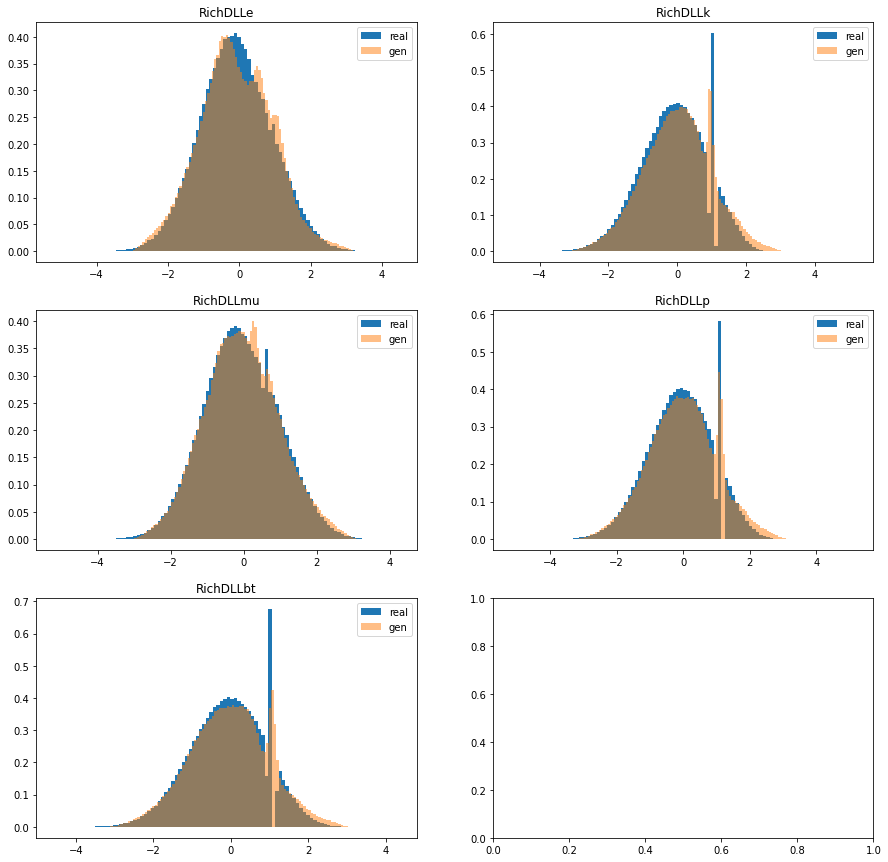

  4%|▍         | 99/2440 [1:30:23<37:15:51, 57.31s/it]

In [ ]:
iteration = 0
for _ in tqdm(range(TOTAL_ITERATIONS*10), position=0, leave=True):
    for x, weight, dll in train_loader:
        iteration += 1
        
        x = x.to(device)
        weight = weight.to(device)
        dll = dll.to(device)
        real_row = torch.cat([dll, x], dim=1)
        
        if iteration % CRITIC_ITERATIONS_CONST != 0:
            
            # Clamp parameters to a range [-c, c], c=self.weight_cliping_limit
            for p in netC.parameters():
                p.data.clamp_(-weight_cliping_limit, weight_cliping_limit)
            
            optC.zero_grad()

            netG.eval()
            netC.train()

            real_loss = netC(real_row)
            fake_dll = netG(x).detach()
            fake_row = torch.cat([fake_dll, x], dim=1)
            fake_loss = netC(fake_row)
            
            critic_loss = (fake_loss.mean() - real_loss.mean()) * weight.mean()
            critic_loss.backward()
            optC.step()
            
            wandb.log({"Critic loss": critic_loss.item()})
        else:
            netC.eval()
            netG.train()

            optG.zero_grad()

            fake_dll = netG(x)
            fake_row = torch.cat([fake_dll, x], dim=1)
            generator_loss = -netC(fake_row).mean() * weight.mean()
            
            generator_loss.backward()
            optG.step()
            
            wandb.log({"Generator loss": generator_loss.item()})

        if iteration % VALIDATION_INTERVAL == 0:
            clear_output(False)
            torch.save(netG.state_dict(),f'G_teacher_10_l1.pth')
            torch.save(netC.state_dict(),f'C_teacher_10_l1.pth')

            dlls = None
            generated = None
            weights = None

            with torch.no_grad():
                for x, weight, real in val_loader:
                    weight = weight.detach().cpu().numpy()
                    dll = real.detach().cpu().numpy()
                    x = x.to(device)
                    gen = netG(x).detach().cpu().numpy()

                    if dlls is None:
                        dlls = dll
                    else:
                        dlls = np.concatenate((dlls, dll))

                    if weights is None:
                        weights = weight
                    else:
                        weights = np.concatenate((weights, weight))

                    if generated is None:
                        generated = gen
                    else:
                        generated = np.concatenate((generated, gen))

                fig, axes = plt.subplots(3, 2, figsize=(15, 15))
                for particle_type, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
                    sns.distplot(dlls[:, particle_type], hist_kws={'weights': weights, 'alpha': 1}, kde=False, bins=100, ax=ax, label="real", norm_hist=True)
                    sns.distplot(generated[:, particle_type], hist_kws={'weights': weights, 'alpha': 0.5}, kde=False, bins=100, ax=ax, label="gen", norm_hist=True)
                    ax.legend()
                    ax.set_title(utils_rich.dll_columns[particle_type])

                plt.show()

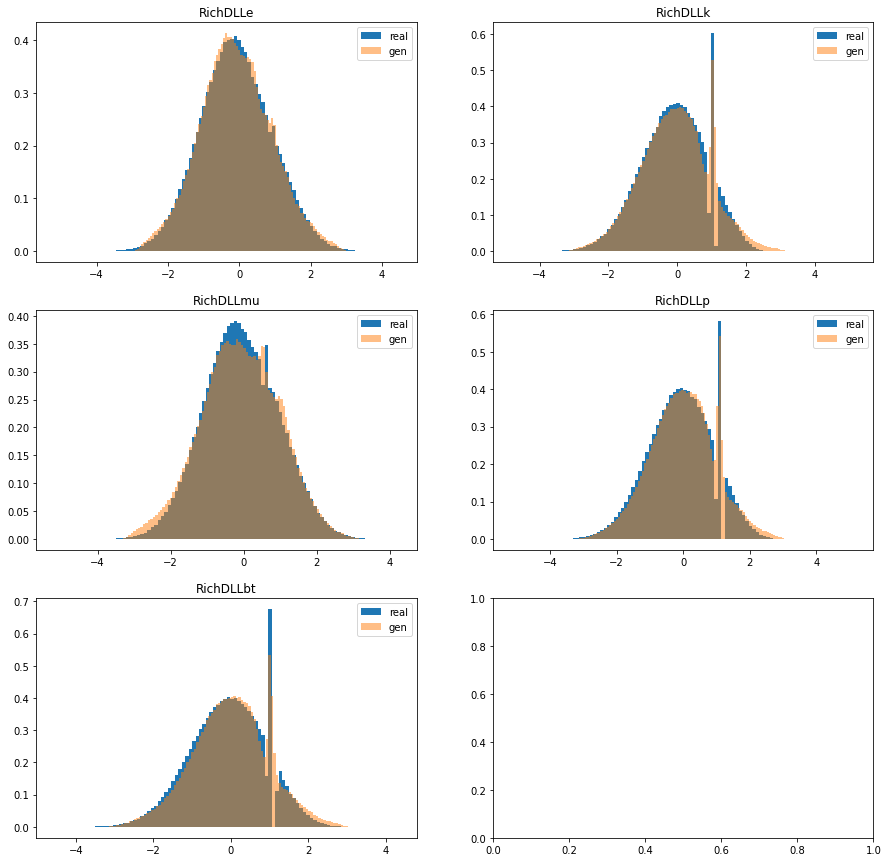

In [25]:
dlls = None
generated = None
weights = None

with torch.no_grad():
    for x, weight, real in val_loader:
        weight = weight.detach().cpu().numpy()
        dll = real.detach().cpu().numpy()[:,:utils_rich.y_count]
        x = x.to(device)
        gen = netG(x).detach().cpu().numpy()

        if dlls is None:
            dlls = dll
        else:
            dlls = np.concatenate((dlls, dll))

        if weights is None:
            weights = weight
        else:
            weights = np.concatenate((weights, weight))

        if generated is None:
            generated = gen
        else:
            generated = np.concatenate((generated, gen))

    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    for particle_type, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
        sns.distplot(dlls[:, particle_type], hist_kws={'weights': weights, 'alpha': 1}, kde=False, bins=100, ax=ax, label="real", norm_hist=True)
        sns.distplot(generated[:, particle_type], hist_kws={'weights': weights, 'alpha': 0.5}, kde=False, bins=100, ax=ax, label="gen", norm_hist=True)
        ax.legend()
        ax.set_title(utils_rich.dll_columns[particle_type])

    plt.show()

## Catboost

In [67]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

y = [1] * dlls.shape[0]
y.extend(list([0] * generated.shape[0]))
exp = np.exp(weights)
y_weights = np.concatenate((exp, exp), axis=0)
X = np.concatenate((dlls, generated))

y = np.expand_dims(y, axis=1)
y_weights = np.expand_dims(y_weights, axis=1)
y = np.concatenate((y, y_weights), axis=1)
y

array([[1.        , 2.36162996],
       [1.        , 2.60510492],
       [1.        , 3.23419476],
       ...,
       [0.        , 2.559129  ],
       [0.        , 2.85117149],
       [0.        , 1.24782872]])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [58]:
classifier = CatBoostClassifier(iterations=1000,
                custom_metric=['Logloss', 'AUC'],
                task_type="GPU",
                devices='0:1')

train_data = Pool(data=X_train,
                  label=y_train[:,0],
                  weight=y_train[:,1])

classifier.fit(train_data,
                verbose=False,
                plot=False);

In [59]:
predicted = classifier.predict(X_test)

In [65]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test[:,0], predicted, pos_label=1, sample_weight=y_test[:,1])
metrics.auc(fpr, tpr)

0.7042764184782561

## Inversed

In [ ]:
dlls = None
generated = None
weights = None
xx = None

with torch.no_grad():
    for x, weight, real in val_loader:
        weight = weight.detach().cpu().numpy()
        dll = real.detach().cpu().numpy()[:,:utils_rich.y_count]
        x = x.to(device)
        gen = netG(x).detach().cpu().numpy()
        x = x.detach().cpu().numpy()

        if xx is None:
            xx = x
        else:
            xx = np.concatenate((xx, x))
        
        if dlls is None:
            dlls = dll
        else:
            dlls = np.concatenate((dlls, dll))

        if weights is None:
            weights = weight
        else:
            weights = np.concatenate((weights, weight))

        if generated is None:
            generated = gen
        else:
            generated = np.concatenate((generated, gen))

Exception: The wandb backend process has shutdown

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

y = [1] * dlls.shape[0]
y.extend(list([0] * generated.shape[0]))
exp = np.exp(weights)
y_weights = np.concatenate((exp, exp), axis=0)
xx = np.concatenate((xx, xx), axis=0)
dlls = np.concatenate((dlls, generated))
X = np.column_stack((dlls, xx))

Exception: The wandb backend process has shutdown

In [ ]:
X = scaler.inverse_transform(X)

Exception: The wandb backend process has shutdown

In [90]:
X = X[:, :-3]

In [92]:
y = np.expand_dims(y, axis=1)
y_weights = np.expand_dims(y_weights, axis=1)
y = np.concatenate((y, y_weights), axis=1)
y

array([[1.        , 2.36162996],
       [1.        , 2.60510492],
       [1.        , 3.23419476],
       ...,
       [0.        , 2.559129  ],
       [0.        , 2.85117149],
       [0.        , 1.24782872]])

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [98]:
classifier = CatBoostClassifier(iterations=1000,
                custom_metric=['Logloss', 'AUC'],
                task_type="GPU",
                devices='0:1')

train_data = Pool(data=X_train,
                  label=y_train[:,0],
                  weight=y_train[:,1])

classifier.fit(train_data,
                verbose=False,
                plot=False);

In [99]:
predicted = classifier.predict(X_test)

In [100]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test[:,0], predicted, pos_label=1, sample_weight=y_test[:,1])
metrics.auc(fpr, tpr)

0.6863010855204051